## Show results - Test 

In [2]:
import numpy as np
import pandas as pd
#from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
import pickle
import palettable
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

sys.path.append('../../')

from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard

from src.impact_calculation.impact_heat import *
from src.util.plots import *

fig_dir = '../figures/'

2020-10-28 16:23:50,067 - climada - DEBUG - Loading default config file: C:\Users\valen\Documents\GitHub\climada_python-1.4.2\climada\conf\defaults.conf


## Damage cost for each scenario, year and labor type

In [3]:
pickle_in = \
open('../../output/mortality_results/impact_100mc2.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

agg_impacts_mc = impacts_mortality.agg_impacts_mc
median_impact_matrices = impacts_mortality.median_impact_matrices


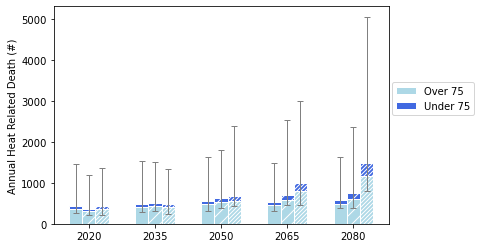

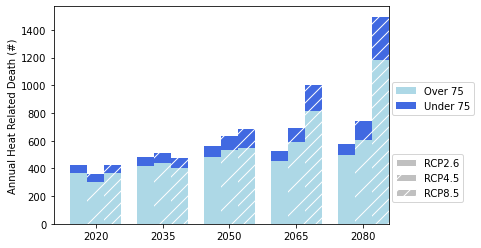

In [4]:
plot_impacts_heat(agg_impacts_mc, 'Annual Heat Related Death (#)', color=['yellowgreen', 'darkolivegreen'])

#plt.savefig(''.join([fig_dir,'loss_ch/predicted_deaths_2020_2080.pdf']),bbox_inches='tight')


## Spatial Impact

In [4]:
category = 'Over 75'
categories_code = {'Over 75':'O', 'Under 75':'U'}
cm = palettable.scientific.sequential.LaJolla_20.mpl_colormap

directory_exposures = '../../input_data/exposures/'
exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_', categories_code[category], '.h5'])
exposures = Exposures()
exposures.read_hdf5(exposures_file)
impact = impacts_mortality.matrix_as_impact(median_impact_matrices['RCP85'][2020][category], exposures, unit='Annual Heat Related Death (#)', percentage=False)
impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1)

2020-10-29 10:12:20,623 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_O.h5


<GeoAxesSubplot:>

ValueError: Expected 2-dimensional array, got 1

<Figure size 648x936 with 2 Axes>

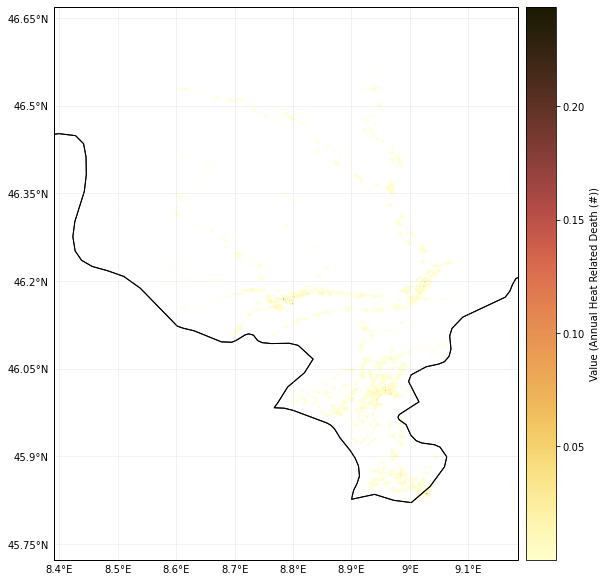

In [7]:
impact_basel = impacts_mortality.matrix_as_impact(median_impact_matrices['RCP85'][2020][category], exposures, unit='Annual Heat Related Death (#)', percentage=False, canton='Basel-Stadt')
#impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1)

## Relative change map

In [9]:
rel_mat = ImpactsHeatMortality.compute_relative_change(median_impact_matrices['RCP85'][2050][category], median_impact_matrices['RCP85'][2020][category])
impacts_rel = ImpactsHeatMortality.matrix_as_impact(rel_mat, exposures)
impacts_rel.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1)



<GeoAxesSubplot:>

ValueError: Expected 2-dimensional array, got 1

<Figure size 648x936 with 2 Axes>

## Canton Impacts

In [6]:
pickle_in = \
open('../../output/mortality_results/impact_100mc.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

agg_impacts_mc = impacts_mortality.agg_impacts_mc
median_impact_matrices = impacts_mortality.median_impact_matrices

directory_exposures = '../../input_data/exposures/'
exposures = {}
for code, category in {'O': 'Over 75', 'U': 'Under 75'}.items():    
    exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_', code,'.h5'])
    exposures[category] = Exposures()
    exposures[category].read_hdf5(exposures_file)
    #exposures[category] = Exposures(exposures[category])
    exposures[category].check()

agg_impact_zurich = impacts_mortality.calculate_impact_agg_canton('Zürich', exposures)


2020-10-28 09:13:53,238 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_O.h5
2020-10-28 09:13:55,245 - climada.entity.exposures.base - INFO - centr_ not set.
2020-10-28 09:13:55,246 - climada.entity.exposures.base - INFO - deductible not set.
2020-10-28 09:13:55,247 - climada.entity.exposures.base - INFO - cover not set.
2020-10-28 09:13:55,247 - climada.entity.exposures.base - INFO - category_id not set.
2020-10-28 09:13:55,248 - climada.entity.exposures.base - INFO - region_id not set.
2020-10-28 09:13:55,249 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_U.h5
2020-10-28 09:13:57,276 - climada.entity.exposures.base - INFO - centr_ not set.
2020-10-28 09:13:57,276 - climada.entity.exposures.base - INFO - deductible not set.
2020-10-28 09:13:57,277 - climada.entity.exposures.base - INFO - cover not set.
2020-10-28 09:13:57,277 - climada.entity.exposures.base - INFO - category_id not s

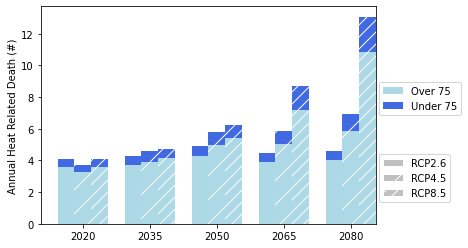

In [7]:
plot_impacts_heat(agg_impact_zurich, 'Annual Heat Related Death (#)',uncertainty=False, color=['yellowgreen', 'darkolivegreen'])